In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import *
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.math import l2_normalize
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import KeyedVectors
from keras import layers


In [ ]:
!wget -P download -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format('download/GoogleNews-vectors-negative300.bin.gz', binary=True)

--2020-12-02 16:21:22--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.229.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.229.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘download/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  79.8MB/s    in 19s     

2020-12-02 16:21:41 (81.6 MB/s) - ‘download/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
(xtrain,ytrain),(xtest,ytest)=imdb.load_data(num_words=5000) 

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
maxlen=500
vocab_size=5000
emb_dimension=300

In [ ]:
maxlen=500
vocab_size=5000
emb_dimension=300
xtrain=pad_sequences(xtrain,maxlen=maxlen,padding='post')
xtest=pad_sequences(xtest,maxlen=maxlen,padding='post')

In [ ]:
word_idx=imdb.get_word_index() #getting vocab from imdb data

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
embedding_matrix = np.zeros((vocab_size,emb_dimension))
for word, i in word_idx.items():
    if word in word2vec.vocab and i<vocab_size:
        embedding_matrix[i] = word2vec.word_vec(word)

In [ ]:
# channel 1
input=Input(shape=(maxlen,))
emb=Embedding(vocab_size,emb_dimension,weights=[embedding_matrix])(input)

x=Bidirectional(keras.layers.GRU(64, return_sequences=True))(emb)
x=Conv1D(64,kernel_size=3,activation='relu')(x)  
x=Dropout(0.5)(x)
x= MaxPool1D()(x)
#x=LSTM(128,kernel_regularizer=keras.regularizers.L2(l2=0.01))(x) #l2=0.001

# channel 2
y=Bidirectional(keras.layers.GRU(64, return_sequences=True))(emb)
y=Conv1D(64,kernel_size=3,activation='relu')(y)  
y=Dropout(0.5)(y)
y= MaxPool1D()(y)
#x=LSTM(128,kernel_regularizer=keras.regularizers.L2(l2=0.01))(x) #l2=0.001

# channel 3
z=Bidirectional(keras.layers.GRU(64, return_sequences=True))(emb)
z=Conv1D(64,kernel_size=3,activation='relu')(z)  
z=Dropout(0.5)(z)
z= MaxPool1D()(z)
#x=LSTM(128,kernel_regularizer=keras.regularizers.L2(l2=0.01))(x) #l2=0.001

# merge
merged = concatenate([x,y,z])
# interpretation
dense1 = Dense(10, activation='relu')(merged)
outputs = Dense(1, activation='sigmoid')(dense1)
model = Model(inputs=input, outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 300)     1500000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 500, 128)     140544      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 500, 128)     140544      embedding[0][0]                  
_______________________________________________________________________________________

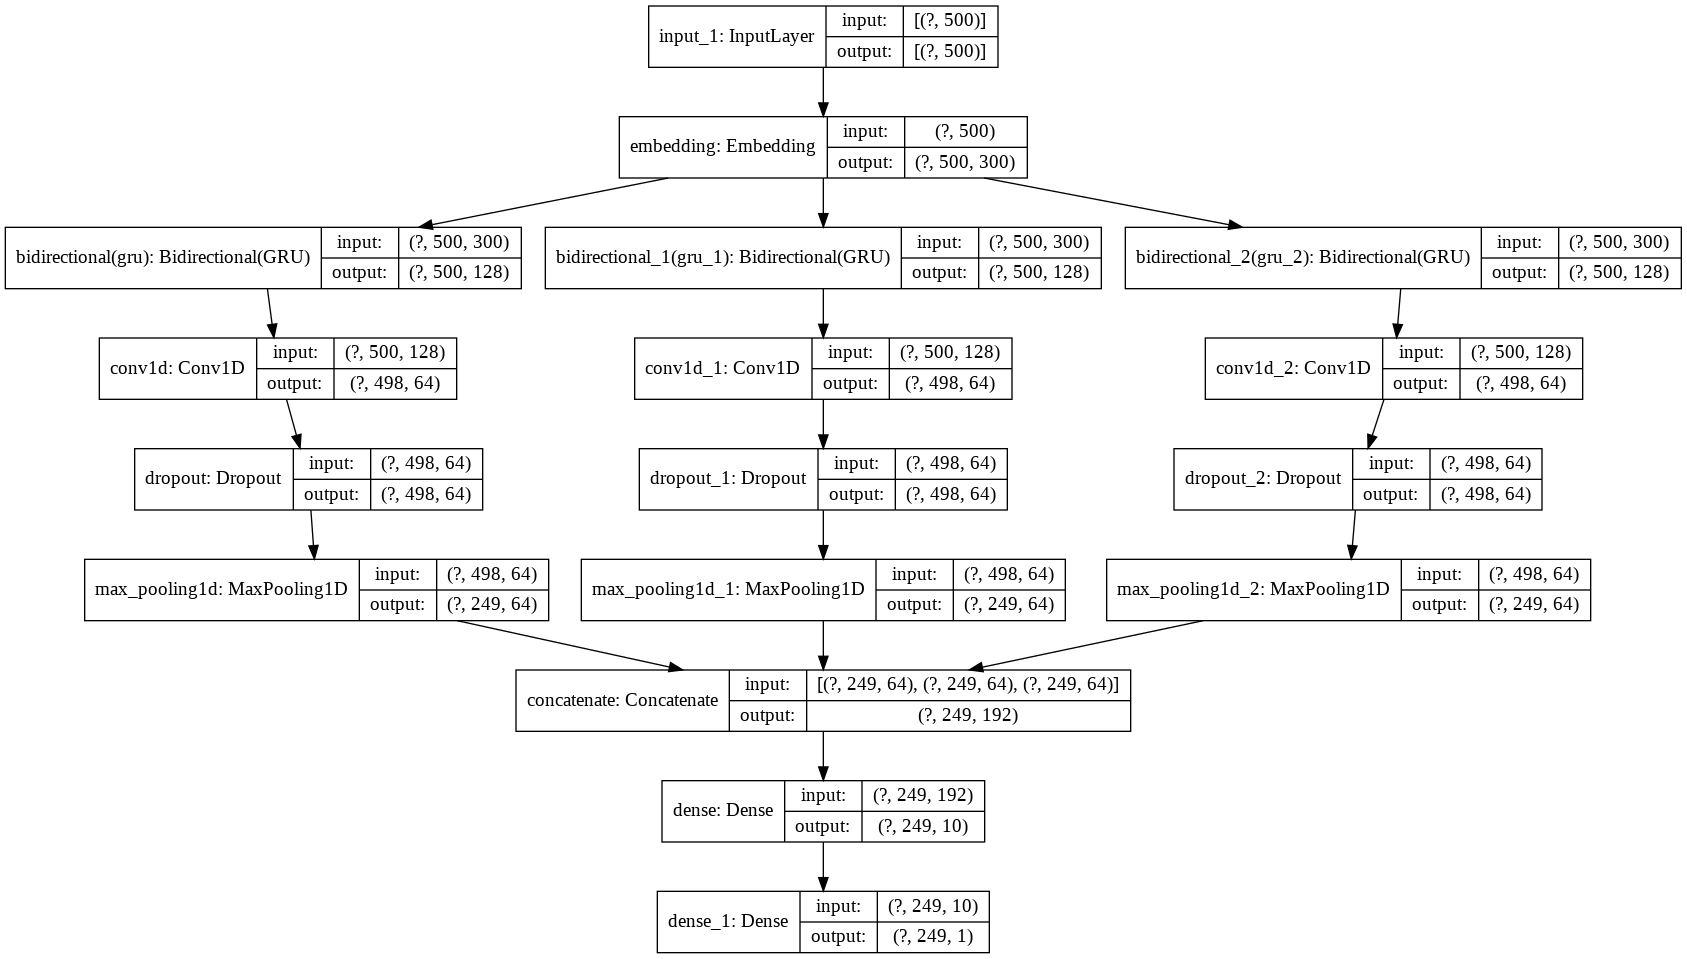

In [ ]:
plot_model(model, show_shapes=True, to_file='multichannel_BiGRU_CNN_maxpool.png')

In [ ]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(xtrain, ytrain, batch_size=256, epochs=10, validation_data=(xtest, ytest))

Epoch 1/10
